# ==================== Calcula Resultado Anual ====================

In [1]:
from pandas import Series
import pandas as pd
from datetime import date
pd.__version__

'1.3.4'

In [2]:
import matplotlib as mat
mat.__version__

'3.4.3'

In [3]:
import time
time.asctime( time.localtime(time.time()) )

'Tue Jun 13 11:37:39 2023'

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [5]:
# Setando opção do Pandas para mostrar todas as linhas
pd.set_option('display.max_rows', None)

In [6]:
# Setando definição de cores
def color_negative_red(val):
    color = 'red' if val < 0 else 'green'
    return 'color: %s' % color

In [7]:
# Setando variáveis

ano = 2023

valor_acerto = 0
arquivo_csv = 'arquivos/relatorioOperacoes' + str(ano) + '.csv'
data_acerto = '31/12/' + str(ano)
# Data, Porcentagem, Resultado, 
matrix_acerto = [['01/07/2020', '-20,79', '0,00', '0', 0],
                 ['01/09/2020', '2,66', '0,00', '0', 0],
                 ['02/02/2021', '-1,84', '0,00', '0', 0],
                 ['17/06/2021', '1,75', '0,00', '0', 0],
                 ['13/06/2023', '3,12', '2945,56', '14300', 6.80]
                ]

In [8]:
# Usando o método read_csv
df = pd.read_csv(arquivo_csv, delimiter=";", encoding='ansi', decimal=",")

In [9]:
df.rename(columns={df.columns.values[0]: 'Data da Operação',
                   df.columns.values[1]: 'temp'}, inplace=True)
del df["temp"]

In [10]:
#Substitui NaN por "-"
df = df.fillna("-")

In [11]:
# Copia coluna "Lucro/Perda (R$)" para novo Dataframe dfTemp
dfTemp = df["Lucro/Perda (R$)"]
dfFinal = df

In [12]:
# Exclui coluna "Lucro/Perda (R$)" do Dataframe dfFinal
del dfFinal["Lucro/Perda (R$)"]

In [13]:
# Copia índices para exclusão do dfTemp
index = df[df['Ativo'] != '-'].index
# Exclui linhas nulas do dfTemp
dfTemp.drop(index, inplace=True)

In [14]:
# Reorganiza índice dfTemp
dfTemp.index = pd.Categorical(dfTemp.index).codes

In [15]:
# Copia índices para exclusão do dfFinal
index = df[df['Ativo'] == '-'].index
# Exclui linhas nulas do dfFinal
dfFinal.drop(index, inplace=True)

In [16]:
# Reorganiza índice dfFinal
dfFinal.index = pd.Categorical(dfFinal.index).codes

In [17]:
dfFinal[dfTemp.name] = dfTemp

In [18]:
# Adicionando linha com acerto
for x in range(len(matrix_acerto)):
    if ano == int(matrix_acerto[x][0][6:10]):
        linha_nova = [matrix_acerto[x][0],
                      'Acerto','Acerto','Acerto','Acerto',
                      str(matrix_acerto[x][3]),
                      str(matrix_acerto[x][4]),
                      0,
                      str(matrix_acerto[x][1]) + ' %',
                      str(matrix_acerto[x][2])]
        dfFinal.loc[len(dfFinal)] = linha_nova

In [19]:
# Conversão da coluna Data de Operação para tipo Data
dfFinal['Data da Operação'] = pd.to_datetime(dfFinal['Data da Operação'], format='%d/%m/%Y')

In [20]:
dfFinal = dfFinal.sort_values(['Data da Operação', 'Tipo Operação'], ascending=[True, False])

In [21]:
# Ajustando caracter de decimal e milhar em "Lucro/Perda (R$)", e conversão para float
dfFinal['Lucro/Perda (R$)'] = [x.replace('.','') for x in dfFinal[dfFinal.columns.values[9]]]
dfFinal['Lucro/Perda (R$)'] = [x.replace(',','.') for x in dfFinal[dfFinal.columns.values[9]]]
dfFinal['Lucro/Perda (R$)'] = dfFinal['Lucro/Perda (R$)'].astype(float)

In [22]:
# Removendo sinal de % para cálculos, e conversão para float
dfFinal['%'] = [x.replace(' %','') for x in dfFinal[dfFinal.columns.values[8]]]
dfFinal['%'] = [x.replace(',','.') for x in dfFinal[dfFinal.columns.values[8]]]
dfFinal['%'] = dfFinal['%'].astype(float)

In [23]:
del dfFinal['Característica']
del dfFinal['Corretora']

In [24]:
dfFinal['Qtde'] = dfFinal['Qtde'].astype(str)
dfFinal['Qtde'] = [x.replace('.','') for x in dfFinal['Qtde']]
dfFinal['Qtde'] = dfFinal['Qtde'].astype(int)

In [25]:
dfFinal['Preço (R$)'] = dfFinal['Preço (R$)'].astype(float)

In [26]:
# Calcula vr_compra
vr_compra_bruto = dfFinal['Qtde'] * dfFinal['Preço (R$)']

In [27]:
emolumentos = 325 / 1000000
corretagem = 49 / 10
vr_compra = vr_compra_bruto + corretagem + (vr_compra_bruto * emolumentos)

In [28]:
dfFinal['Valor Compra'] = vr_compra

In [29]:
# dfFinal.style.applymap(color_negative_red, subset=['%','Lucro/Perda (R$)'])

In [30]:
# Cria Dataframe com apenas Porcentagem e Lucro/Perda (R$)
df_sum = dfFinal[['%', 'Lucro/Perda (R$)']].copy()

In [31]:
df_sum.columns.values[0] = 'Porcentagem'

In [32]:
# Agrupa por mês totalizando o lucro/Prejuízo
df_sum_lucro_perda = dfFinal.groupby(dfFinal['Data da Operação']
                                     .dt.strftime('%B'))['Lucro/Perda (R$)'].sum()

In [33]:
# Agrupa por mês totalizando a Porcentagem
df_sum_porcentagem = dfFinal.groupby(dfFinal['Data da Operação']
                                     .dt.strftime('%B'))['%'].sum()

In [34]:
#dfFinal

In [35]:
df_sum_porcentagem

Data da Operação
April       16.44
February   -50.27
January    -10.42
June        10.48
March       -3.58
May         16.86
Name: %, dtype: float64

In [36]:
dfFinal_teste = dfFinal.groupby(['Data da Operação', 'Tipo Operação']).sum(['Lucro/Perda (R$)', 'Valor Compra'])
dfFinal_teste.reset_index(drop=False, inplace=True)
#dfFinal_teste

In [37]:
# del dfFinal_teste['Preço (R$)']
del dfFinal_teste['%']
dfFinal_teste['%'] = (dfFinal_teste['Lucro/Perda (R$)'] * 100) / dfFinal_teste['Valor Compra']
#dfFinal_teste

In [38]:
dfFinal_teste['Data da Operação'] = pd.to_datetime(dfFinal_teste['Data da Operação'], format='%d/%m/%Y')
df_sum_porcentagem_teste = dfFinal_teste.groupby(dfFinal_teste['Data da Operação']
                                     .dt.strftime('%B'))['%'].sum()

In [39]:
df_sum_porcentagem_teste

Data da Operação
April       14.979089
February   -16.737272
January    -37.056878
June        10.306591
March      -11.774715
May         15.148849
Name: %, dtype: float64

In [40]:
# df_sum_porcentagem.style.applymap(color_elements)

In [41]:
array_meses = [4,8,12,2,1,7,6,3,5,11,10,9]
meses = []
if date.today().year == ano:
    for x in array_meses:
        if x <= date.today().month:
            meses.append(x)
else:
    meses = array_meses

In [42]:
date.today().year

2023

In [43]:
# Cria DataFrame
df_tot_mes = pd.DataFrame({'cd_mes':meses
                         ,'Mês':df_sum_lucro_perda.index.values
                         ,'Lucro/Perda (R$)':df_sum_lucro_perda
                         ,'Porcentagem':df_sum_porcentagem})

In [44]:
df_tot_mes = df_tot_mes.set_index('cd_mes')

In [45]:
df_tot_mes.sort_index(inplace=True)

In [46]:
# Setando separador de milhar
pd.options.display.float_format = '{:,.2f}'.format

# Total no Ano

In [47]:
df_sum.sum()

Porcentagem           -20.49
Lucro/Perda (R$)   11,858.97
dtype: float64

## Resultado Mensal

In [48]:
# df_tot_mes.style.applymap(color_negative_red, subset=['Lucro/Perda (R$)','Porcentagem'])
df_tot_mes

,Mês,Lucro/Perda (R$),Porcentagem
cd_mes,,,
1,January,"-3,864.89",-10.42
2,February,"-9,479.17",-50.27
3,March,"-7,345.13",-3.58
4,April,"10,502.29",16.44
5,May,"12,478.47",16.86
6,June,"9,567.40",10.48


In [49]:
dfFinal['Qtde'] = dfFinal.loc[:, 'Qtde'].astype(int).map('{:,}'.format)
dfFinal

,Data da Operação,Tipo Operação,Ativo,Qtde,Preço (R$),Custo Médio (R$),%,Lucro/Perda (R$),Valor Compra
1,2023-01-03,Venda,YDUQ3,"8,700",9.65,10.17,-5.05,"-4,470.76","83,987.19"
0,2023-01-03,Compra,GFSA3,500,21.30,0.00,0.00,0.00,"10,658.36"
3,2023-01-04,Venda,GFSA3,500,15.69,21.31,-26.33,"-2,805.55","7,852.45"
2,2023-01-04,Compra,AMER3,"9,200",8.73,0.00,0.00,0.00,"80,347.00"
4,2023-01-05,Venda,AMER3,"9,200",8.82,8.73,1.08,871.53,"81,175.27"
5,2023-01-05,Compra,YDUQ3,"8,600",9.41,0.00,0.00,0.00,"80,957.20"
6,2023-01-06,Venda,YDUQ3,"8,600",9.51,9.41,1.10,897.16,"81,817.48"
7,2023-01-09,Compra,AMER3,"7,400",11.08,0.00,0.00,0.00,"82,023.55"
8,2023-01-10,Venda,AMER3,"7,400",11.10,11.08,0.18,155.74,"82,171.60"
9,2023-01-10,Compra,YDUQ3,"8,300",9.77,0.00,0.00,0.00,"81,122.25"


<IPython.core.display.Javascript object>


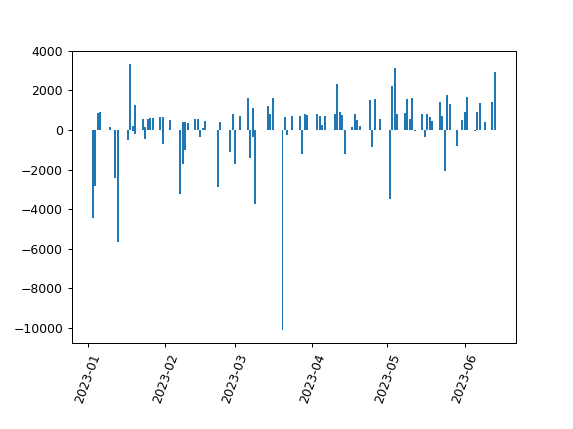

In [50]:
plt.xticks(rotation=70)
plt.subplots_adjust(bottom=0.20)
plt.bar(dfFinal[dfFinal.columns.values[0]], dfFinal[dfFinal.columns.values[7]])
plt.show()

### ======================================== TESTES ========================================

from subprocess import Popen
p = Popen("Executa.bat", cwd=r"C:\Users\esmer\Desktop\Alexandre\Projeto Git\StockManager")
stdout, stderr = p.communicate()

In [51]:
import pandas as pd

example = {'Team':['Australia', 'England', 'South Africa',
                   'Australia', 'England', 'India', 'India',
                        'South Africa', 'England', 'India'],
                          
           'Player':['Ricky Ponting', 'Joe Root', 'Hashim Amla',
                     'David Warner', 'Jos Buttler', 'Virat Kohli',
                     'Rohit Sharma', 'David Miller', 'Eoin Morgan',
                                                 'Dinesh Karthik'],
                                                   
          'Runs':[345, 336, 689, 490, 989, 672, 560, 455, 342, 376],
            
          'Salary':[34500, 33600, 68900, 49000, 98899,
                    67562, 56760, 45675, 34542, 31176] }
  
dfa = pd.DataFrame(example)

In [52]:
dfa

,Team,Player,Runs,Salary
0,Australia,Ricky Ponting,345,34500
1,England,Joe Root,336,33600
2,South Africa,Hashim Amla,689,68900
3,Australia,David Warner,490,49000
4,England,Jos Buttler,989,98899
5,India,Virat Kohli,672,67562
6,India,Rohit Sharma,560,56760
7,South Africa,David Miller,455,45675
8,England,Eoin Morgan,342,34542
9,India,Dinesh Karthik,376,31176


In [53]:
total_salary = dfa.groupby(['Team', 'Runs']).mean('Salary')

In [54]:
total_salary

Salary
Team         Runs          
Australia    345  34,500.00
             490  49,000.00
England      336  33,600.00
             342  34,542.00
             989  98,899.00
India        376  31,176.00
             560  56,760.00
             672  67,562.00
South Africa 455  45,675.00
             689  68,900.00

In [55]:
df_agg = dfFinal.loc[dfFinal['Data da Operação'] > '2021-11-01']
df_agg

,Data da Operação,Tipo Operação,Ativo,Qtde,Preço (R$),Custo Médio (R$),%,Lucro/Perda (R$),Valor Compra
1,2023-01-03,Venda,YDUQ3,"8,700",9.65,10.17,-5.05,"-4,470.76","83,987.19"
0,2023-01-03,Compra,GFSA3,500,21.30,0.00,0.00,0.00,"10,658.36"
3,2023-01-04,Venda,GFSA3,500,15.69,21.31,-26.33,"-2,805.55","7,852.45"
2,2023-01-04,Compra,AMER3,"9,200",8.73,0.00,0.00,0.00,"80,347.00"
4,2023-01-05,Venda,AMER3,"9,200",8.82,8.73,1.08,871.53,"81,175.27"
5,2023-01-05,Compra,YDUQ3,"8,600",9.41,0.00,0.00,0.00,"80,957.20"
6,2023-01-06,Venda,YDUQ3,"8,600",9.51,9.41,1.10,897.16,"81,817.48"
7,2023-01-09,Compra,AMER3,"7,400",11.08,0.00,0.00,0.00,"82,023.55"
8,2023-01-10,Venda,AMER3,"7,400",11.10,11.08,0.18,155.74,"82,171.60"
9,2023-01-10,Compra,YDUQ3,"8,300",9.77,0.00,0.00,0.00,"81,122.25"


In [56]:
df_agg.loc('2021-11-03':'2021-11-10', 'Data da Operação')

SyntaxError: invalid syntax (Temp/ipykernel_27880/860119016.py, line 1)

In [ ]:
df_agg.groupby(['Data da Operação', 'Tipo Operação', 'Ativo']) \
              .agg(teste1 = ('%', 'mean'), teste2 = ('Lucro/Perda (R$)', 'mean')) \
              .sort_values(['Data da Operação', 'Tipo Operação'], ascending=[True, False])

In [ ]:
df_teste = dfFinal.loc[dfFinal['Data da Operação'] > '2023-01-15'].groupby(['Data da Operação', 'Tipo Operação']).sum(['Lucro/Perda (R$)', 'Valor Compra'])

In [ ]:
del df_teste['Preço (R$)']
del df_teste['%']

In [ ]:
df_teste['%'] = (df_teste['Lucro/Perda (R$)'] * 100) / df_teste['Valor Compra']

In [ ]:
df_teste

In [ ]:
df_teste